# Amazon Fine Food Reviews Analysis


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10




Attribute Information:

1.Id
2.ProductId - unique identifier for the product
3.UserId - unqiue identifier for the user
4.ProfileName
5.HelpfulnessNumerator - number of users who found the review helpful
6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7.Score - rating between 1 and 5
8.Time - timestamp for the review
9.Summary - brief summary of the review
10.Text - text of the review




Objective:

Perform EDA on dataset and check whether we can separate positive and negative points to define a hyper-plane.Use T-SNE


# Loading the data


The dataset is available in two forms

1) .csv file
2)  SQLite Database




In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. 
Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative"

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [2]:
filtered_data=pd.read_csv('Reviews.csv')

In [3]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
filtered_data.dropna(inplace=True)
filtered_data[filtered_data['Score']!=3]
filtered_data['positivity']=np.where(filtered_data['Score']>3,1,0)
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,positivity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


In [7]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [8]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
filtered_data.shape

(525814, 10)

# Creating sub-dataset from dataframe

Using 10000 data points from dataframe to create new dataset

In [10]:
sub_data=filtered_data[0:10000]
sub_data.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [11]:
print(sub_data.shape)

(10000, 10)


In [12]:
sub_data['Score'].value_counts()

positive    8321
negative    1679
Name: Score, dtype: int64

## Converting reviews into vectors and using dimension reduction techniques to visualise data using T-SNE

# Bag of Words

In [5]:
count_vect=CountVectorizer()
vect=count_vect.fit_transform(sub_data['Text'].values)

In [6]:
type(vect)

scipy.sparse.csr.csr_matrix

In [11]:
vect.todense()
vect.shape

(50000, 40111)

# T-SVD


Using T-SVD to know about variance, as we know variance indicates the information

Objective: To retain maximum variance

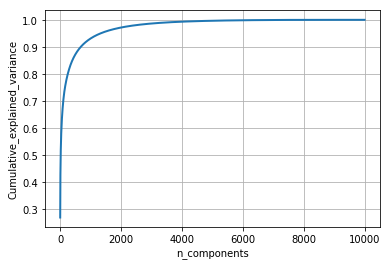

In [7]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD


review=sub_data['Score']

model=TruncatedSVD(n_components=10000)
tsvd_data=model.fit_transform(vect)


percentage_var_explained = model.explained_variance_ / np.sum(model.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)


plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

###### Observation:
From the graph we observe that almost 100% of variance is explained if we take 4000 dimensions

# T-SNE Visualisation for Bag of Words(BoW)

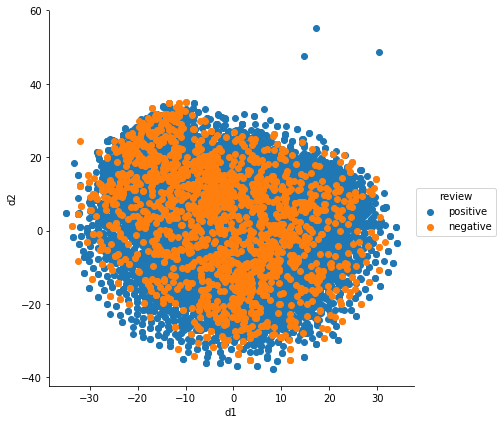

In [12]:


model=TruncatedSVD(n_components=4000)
tsvd_data=model.fit_transform(vect)


model_tsne=TSNE(n_components=2,random_state=0,perplexity=50)
tsne_data=model_tsne.fit_transform(tsvd_data)

tsne_data=np.vstack((tsne_data.T,review)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=('d1','d2','review'))



sns.FacetGrid(tsne_df,hue='review',size=6).map(plt.scatter,'d1','d2').add_legend()
plt.show()

Observation:

The positive and negative reviews are overlapping when we use BoW(Bag of words)

# Bi-Grams


In [13]:
count_vect2=CountVectorizer(ngram_range=(1,2))
vect2=count_vect2.fit_transform(sub_data['Text'].values)

In [14]:
print(vect2.shape)

(10000, 241684)


In [15]:
vect2.todense()
vect2.shape

(10000, 241684)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD


model=TruncatedSVD(n_components=10000)
tsvd_data=model.fit_transform(vect2)


percentage_var_explained = model.explained_variance_ / np.sum(model.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)


plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

## T-SNE Visualisation for Bi-grams

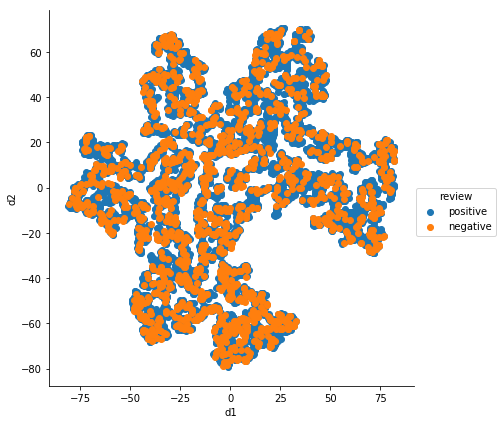

In [15]:

model2=TruncatedSVD(n_components=2)
tsvd_data2=model2.fit_transform(vect2)

model_tsne2=TSNE(n_components=2,random_state=0,perplexity=50)
tsne_data2=model_tsne2.fit_transform(tsvd_data)

tsne_data2=np.vstack((tsne_data2.T,review)).T
tsne_df2=pd.DataFrame(data=tsne_data2,columns=('d1','d2','review'))



sns.FacetGrid(tsne_df2,hue='review',size=6).map(plt.scatter,'d1','d2').add_legend()
plt.show()

###### Obeservation:

The positive and negative reviews are overlapping when we use Bi-grams

## TF-IDF

In [16]:
tf_idf_vect=TfidfVectorizer(ngram_range=(1,2))
tf_idf=tf_idf_vect.fit_transform(sub_data['Text'].values)

In [17]:
print(tf_idf.shape)

(10000, 241684)


## T-SNE Visualisation for TF-IDF

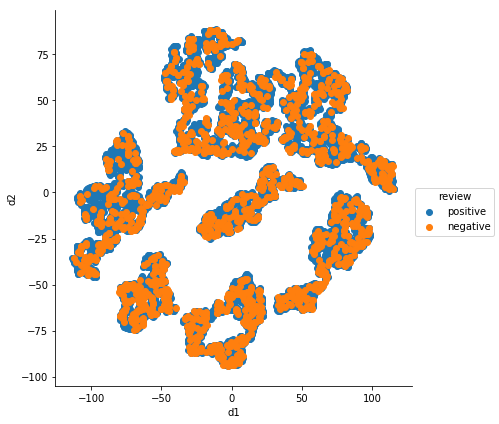

In [19]:
model3=TruncatedSVD(n_components=2)
tsvd_data3=model3.fit_transform(tf_idf)

model_tsne3=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
tsne_data3=model_tsne3.fit_transform(tsvd_data3)

tsne_data3=np.vstack((tsne_data3.T,review)).T
tsne_df3=pd.DataFrame(data=tsne_data3,columns=('d1','d2','review'))

sns.FacetGrid(tsne_df3,hue='review',size=6).map(plt.scatter,'d1','d2').add_legend()
plt.show()

###### Observation:
The positive and negative reviews are overlapping when we use TF-IDF

## Removing HTML tags and Punctuations

In [32]:

import re
import string



def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


# Word2Vec

In [34]:
# WE Train our own Word2Vec model using your own text corpus


i=0
list_of_sent=[]
for sent in sub_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [1]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [37]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50,workers=4)

In [44]:
w2v_model.wv.most_similar('tasty')

[('satisfying', 0.875969409942627),
 ('thin', 0.8590941429138184),
 ('yummy', 0.8558367490768433),
 ('light', 0.8401414155960083),
 ('crunchy', 0.8366321325302124),
 ('soft', 0.8311433792114258),
 ('salty', 0.8215571641921997),
 ('flavorful', 0.8159714937210083),
 ('delicious', 0.8097951412200928),
 ('filling', 0.8062399625778198)]

In [38]:
words = list(w2v_model.wv.vocab)
print(len(words))

5927


In [42]:
w2v=np.asmatrix(w2v_model)

### Avg-W2V

In [52]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
type(sent_vectors)

10000
50


list

## T-SNE Visualisation for Avg-W2V

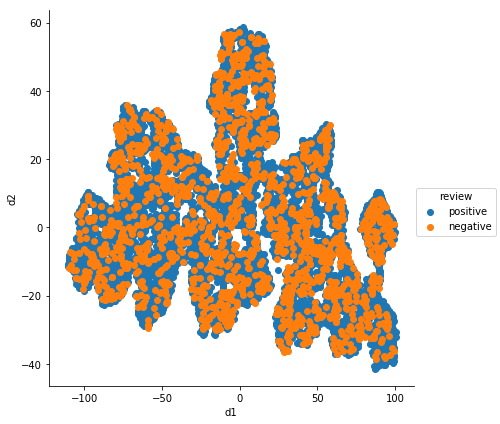

In [47]:
model4=TruncatedSVD(n_components=2)
tsvd_data4=model4.fit_transform(sent_vectors)

model_tsne4=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
tsne_data4=model_tsne4.fit_transform(tsvd_data4)

tsne_data4=np.vstack((tsne_data4.T,review)).T
tsne_df4=pd.DataFrame(data=tsne_data4,columns=('d1','d2','review'))

sns.FacetGrid(tsne_df4,hue='review',size=6).map(plt.scatter,'d1','d2').add_legend()
plt.show()

###### Observation:
We observe that positive and negative reviews are overlapping when we use AVG-W2C